In [4]:
import pandas as pd

fire_data = pd.read_csv(r'working data\fire_data8423.csv')
fire_data = fire_data.dropna()
pivoted_weather= pd.read_csv(r'working data\weather_pivoted.csv')
# Drop columns if they exist
columns_to_drop = ['CONT_DATE', '_id']
fire_data = fire_data.drop(columns=[col for col in columns_to_drop if col in fire_data.columns])
#try merging with unpivoted index weather data, tall and skinny data

print(pivoted_weather['date'].dtype)
print(fire_data['ALARM_DATE'].dtype)


object
object


In [5]:

# Convert 'date' column to datetime
pivoted_weather['date'] = pd.to_datetime(pivoted_weather['date'])
fire_data['ALARM_DATE'] = pd.to_datetime(fire_data['ALARM_DATE'])

#Filter rows between 1984-01-01 and 2023-12-31
pivoted_weather = pivoted_weather[(pivoted_weather['date'] >= '1984-01-01') & (pivoted_weather['date'] <= '2023-12-31')]
fire_data = fire_data[(fire_data['ALARM_DATE'] >= '19840101') & (fire_data['ALARM_DATE'] <= '20231231')]



In [6]:
# Rename columns to match index names before setting index
pivoted_weather.rename(columns={'id': 'weatherstn', 'date': 'ALARM_DATE'}, inplace=True)

# Set index before merging (Speeds up join operations)
pivoted_weather.set_index(['weatherstn', 'ALARM_DATE'], inplace=True)
fire_data.set_index(['weatherstn', 'ALARM_DATE'], inplace=True)

# Perform index-based merge
pivotedweather_fire_merge = pivoted_weather.merge(fire_data, left_index=True, right_index=True, how='left')

# Reset index if needed
pivotedweather_fire_merge.reset_index(inplace=True)

To get only days with fire

In [7]:
pivotedweather_fire_merge_reg= pivotedweather_fire_merge[pivotedweather_fire_merge['Shape__Area'].notna()]

### Dropping columns with too little notnull rows

In [10]:
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.ensemble import RandomForestRegressor
pivotedweather_fire_merge_reg= pd.read_csv(r'working data\pivotedweather_fire_merge_reg.csv')
#check NaN in each column
column_notnull = pivotedweather_fire_merge_reg.notnull().sum()

column_todrop= column_notnull.index[column_notnull<50].to_list()

pivotedweather_fire_merge_drop = pivotedweather_fire_merge_reg.drop(columns=column_todrop)
#pivotedweather_fire_merge_drop is the one with empty column dropped


Imputating NaN data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# Load data
pivotedweather_fire_merge_drop = pd.read_csv(r'working data\pivotedweather_fire_merge_drop.csv')

# Select only numerical columns for imputation
numerical_cols = pivotedweather_fire_merge_drop.loc[:, 'EVAP':'WDMV'].columns  # If continuous
# If non-continuous, use:
# numerical_cols = ['EVAP', 'TEMP', 'HUMID', 'WDMV']  # Add all numerical column names manually

numerical_data = pivotedweather_fire_merge_drop[numerical_cols]

# Initialize and apply IterativeImputer
imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=20, random_state=42)
numerical_data_imputed = imputer.fit_transform(numerical_data)

# Convert back to DataFrame
pivotedweather_fire_merge_drop[numerical_cols] = numerical_data_imputed  # Only update imputed columns

# Check if missing values are handled
print(pivotedweather_fire_merge_drop.isnull().sum())




## RUN THIS FOR THE DATA 

In [2]:
import pandas as pd
#rename the dataframe
pivoted_weather_ready = pd.read_csv(r'working data\pivotedweather_fire_imputated.csv')
# Drop column: 'SNOW'
#pivoted_weather_ready = pivoted_weather_ready.drop(columns=['SNOW'])
# Define Features (X) and Target (y)

X = pivoted_weather_ready.loc[:, 'EVAP':'WDMV']  # Select numerical features
Y = pivoted_weather_ready[['GIS_ACRES', 'Shape__Area', 'Shape__Length']]  # Target variables


### Regression Tree on PRCP only

In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Select only PRCP as feature and GIS_ACRES as target
X = pivoted_weather_ready[['PRCP']]
y = pivoted_weather_ready['GIS_ACRES']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Decision Tree Regressor
model = DecisionTreeRegressor(max_depth=2,random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate model performance
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error: {rmse}')
print(f'Training R2 Score: {train_r2}')
print(f'Test R2 Score: {test_r2}')


Root Mean Squared Error: 8419.872105424942
Training R2 Score: 0.008832766737127407
Test R2 Score: -0.17545804399438114


#### 4 years training,2 years testing ML trial

In [9]:
##to do the 4 years train data, 2 years test data

# Define train/test date ranges
train_start = '2017-01-01'
train_end = '2020-12-31'  # 4 years for training
test_start = '2021-01-01'
test_end = '2022-12-31' # 2 years for testing

# Train-test split using date ranges
train_data = pivoted_weather_ready[
    (pivoted_weather_ready['ALARM_DATE'] >= train_start) & 
    (pivoted_weather_ready['ALARM_DATE'] <= train_end)
]

test_data = pivoted_weather_ready[
    (pivoted_weather_ready['ALARM_DATE'] >= test_start) & 
    (pivoted_weather_ready['ALARM_DATE'] <= test_end)
]

X_train42 = train_data.loc[:, 'EVAP':'WDMV']
Y_train42 = train_data[['GIS_ACRES', 'Shape__Area', 'Shape__Length']]

X_test42 = test_data.loc[:, 'EVAP':'WDMV']
Y_test42 = test_data[['GIS_ACRES', 'Shape__Area', 'Shape__Length']]

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train Model
model42 = RandomForestRegressor(n_estimators=5, random_state=42)
model42.fit(X_train42, Y_train42)

# Predict
Y_pred42 = model42.predict(X_test42)

# Evaluate Performance
mse = mean_squared_error(Y_test42, Y_pred42)
r2 = r2_score(Y_test42, Y_pred42)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R² Score: {r2:.4f}')


Mean Squared Error: 58857111223946472.0000
R² Score: -0.0490


Now the R2 score is -0.0549:
troubleshooting:
1. check if there is NaN in the columns
2. check feature correlation
3. plot a scatterplot between feature and fire parameters (area)

## Correlation matrix

In [11]:
X_train42.isna().sum()
#none of the column has NAN
# Calculate the correlation matrix for the specified columns
correlation_matrix = pivoted_weather_ready.loc[:, 'EVAP':'WDMV'].join(pivoted_weather_ready.loc[:, 'GIS_ACRES':'Shape__Length']).corr()

# Print the correlation matrix
print(correlation_matrix)

                   EVAP      MNPN      MXPN      PRCP      SNWD      TAVG  \
EVAP           1.000000  0.738330  0.825430 -0.207756 -0.207782  0.828659   
MNPN           0.738330  1.000000  0.893118 -0.196266 -0.203241  0.910807   
MXPN           0.825430  0.893118  1.000000 -0.202742 -0.217721  0.958524   
PRCP          -0.207756 -0.196266 -0.202742  1.000000  0.224046 -0.240228   
SNWD          -0.207782 -0.203241 -0.217721  0.224046  1.000000 -0.312565   
TAVG           0.828659  0.910807  0.958524 -0.240228 -0.312565  1.000000   
TMAX           0.699048  0.847176  0.867228 -0.242713 -0.285901  0.915834   
TMIN           0.743617  0.807604  0.816376 -0.181434 -0.230275  0.844307   
TOBS           0.769961  0.783350  0.815955 -0.228342 -0.267662  0.816315   
WDMV          -0.300153 -0.591971 -0.647791  0.037200  0.071415 -0.637127   
GIS_ACRES      0.022042  0.023107  0.018943 -0.010354 -0.005949  0.019267   
Shape__Area    0.020787  0.021650  0.017761 -0.010146 -0.005856  0.017987   

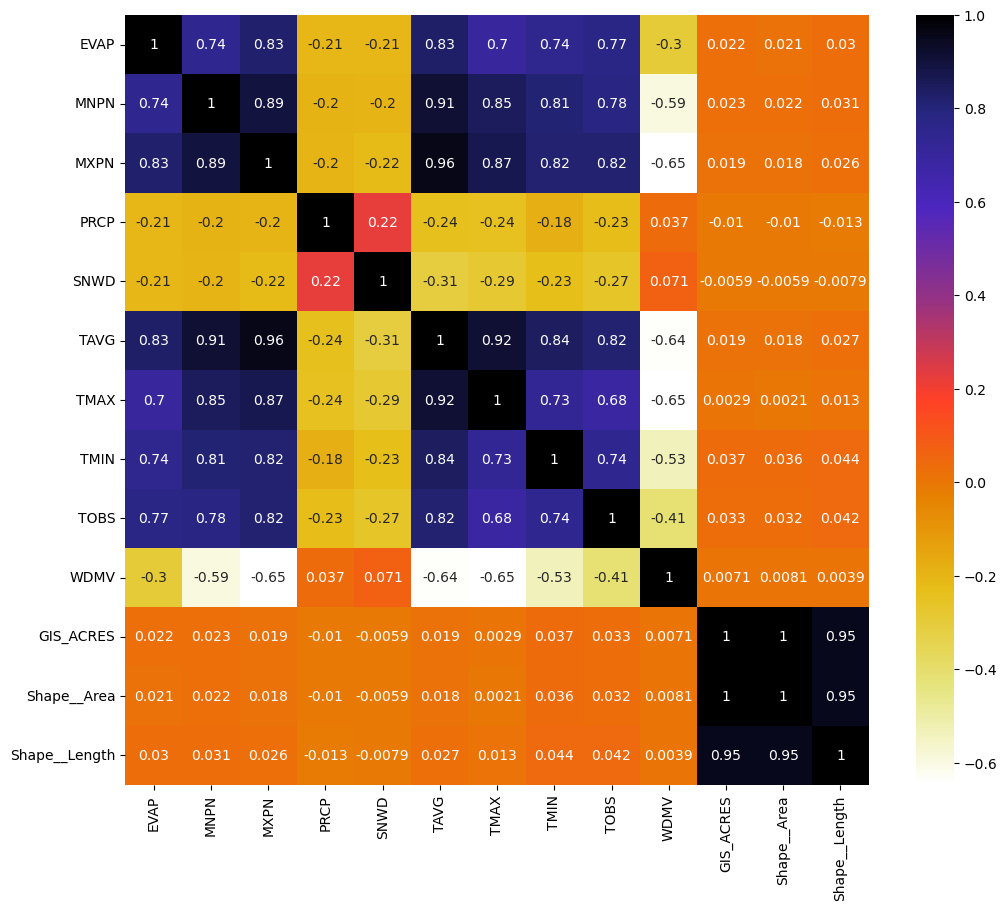

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
#Using Pearson Correlation
plt.figure(figsize=(12,10))
correlation_matrix
sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

['EVAP', 'MNPN', 'MXPN', 'PRCP', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'TOBS', 'WDMV', 'GIS_ACRES', 'Shape__Area', 'Shape__Length']


### weather features against GIS_ACRES

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select features and target
features = ['EVAP', 'MNPN', 'MXPN', 'PRCP', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'TOBS', 'WDMV']  # Add other relevant features
target = 'GIS_ACRES'

# Scatterplots for each feature vs. fire size
for feature in features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=pivoted_weather_ready[feature], y=pivoted_weather_ready[target])
    plt.xlim(pivoted_weather_ready[feature].min(), pivoted_weather_ready[feature].max())
    plt.ylim(pivoted_weather_ready[target].min(), pivoted_weather_ready[target].max())
    plt.xlabel(feature+"logscale")
    plt.ylabel(target)
    plt.title(f'{feature} vs {target}')
    plt.yscale('log') #log to see the data trend more clearly, normal scatter shows all datapoints stick to the bottom)
    plt.show()


#### Regression plot: show correlation, for loop
#### Removed outlier to make graph look more focused on the most datapoints

In [170]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define features and targets
features = ['EVAP', 'MNPN', 'MXPN', 'PRCP', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'TOBS', 'WDMV']
targets = ['GIS_ACRES', 'Shape__Area', 'Shape__Length']

# Function to remove extreme outliers based on percentiles
def remove_outliers(df, feature, target, lower=1, upper=99):
    lower_bound_feature, upper_bound_feature = np.percentile(df[feature].dropna(), [lower, upper])
    lower_bound_target, upper_bound_target = np.percentile(df[target].dropna(), [lower, upper])
    
    return df[
        (df[feature] >= lower_bound_feature) & (df[feature] <= upper_bound_feature) &
        (df[target] >= lower_bound_target) & (df[target] <= upper_bound_target)
    ]

# Loop through each target variable
for target in targets:
    for feature in features:
        # Remove extreme outliers
        filtered_data = remove_outliers(pivoted_weather_ready, feature, target)
        
        # Create a separate figure for each feature-target pair
        plt.figure(figsize=(6, 4))  
        
        sns.regplot(x=filtered_data[feature], 
                    y=filtered_data[target], 
                    scatter_kws={'alpha': 0.3},  # Transparency for overlapping points
                    line_kws={'color': 'red'})  # Regression line in red
        
        plt.xlabel(feature)
        plt.ylabel(target)
        plt.title(f"{feature} vs {target}")
        
        plt.show()


KeyboardInterrupt: 

#### Shifting window for 4 years, 2 years train-test: for loop

In [ ]:
for start_year in range(2000, 2020, 2):  # Adjust range based on dataset
    train_years = list(range(start_year, start_year + 4))
    test_years = list(range(start_year + 4, start_year + 6))
    
    train_data = pivotedweather_fire_merge_drop[pivotedweather_fire_merge_drop['year'].isin(train_years)]
    test_data = pivotedweather_fire_merge_drop[pivotedweather_fire_merge_drop['year'].isin(test_years)]
    
    X_train, y_train = train_data.loc[:, 'EVAP':'WDMV'], train_data[['GIS_ACRES', 'Shape__Area', 'Shape__Length']]
    X_test, y_test = test_data.loc[:, 'EVAP':'WDMV'], test_data[['GIS_ACRES', 'Shape__Area', 'Shape__Length']]
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"Train Years: {train_years} | Test Years: {test_years}")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}, R²: {r2_score(y_test, y_pred):.4f}")
    print("-" * 50)


### plotting the scatterplot matrix

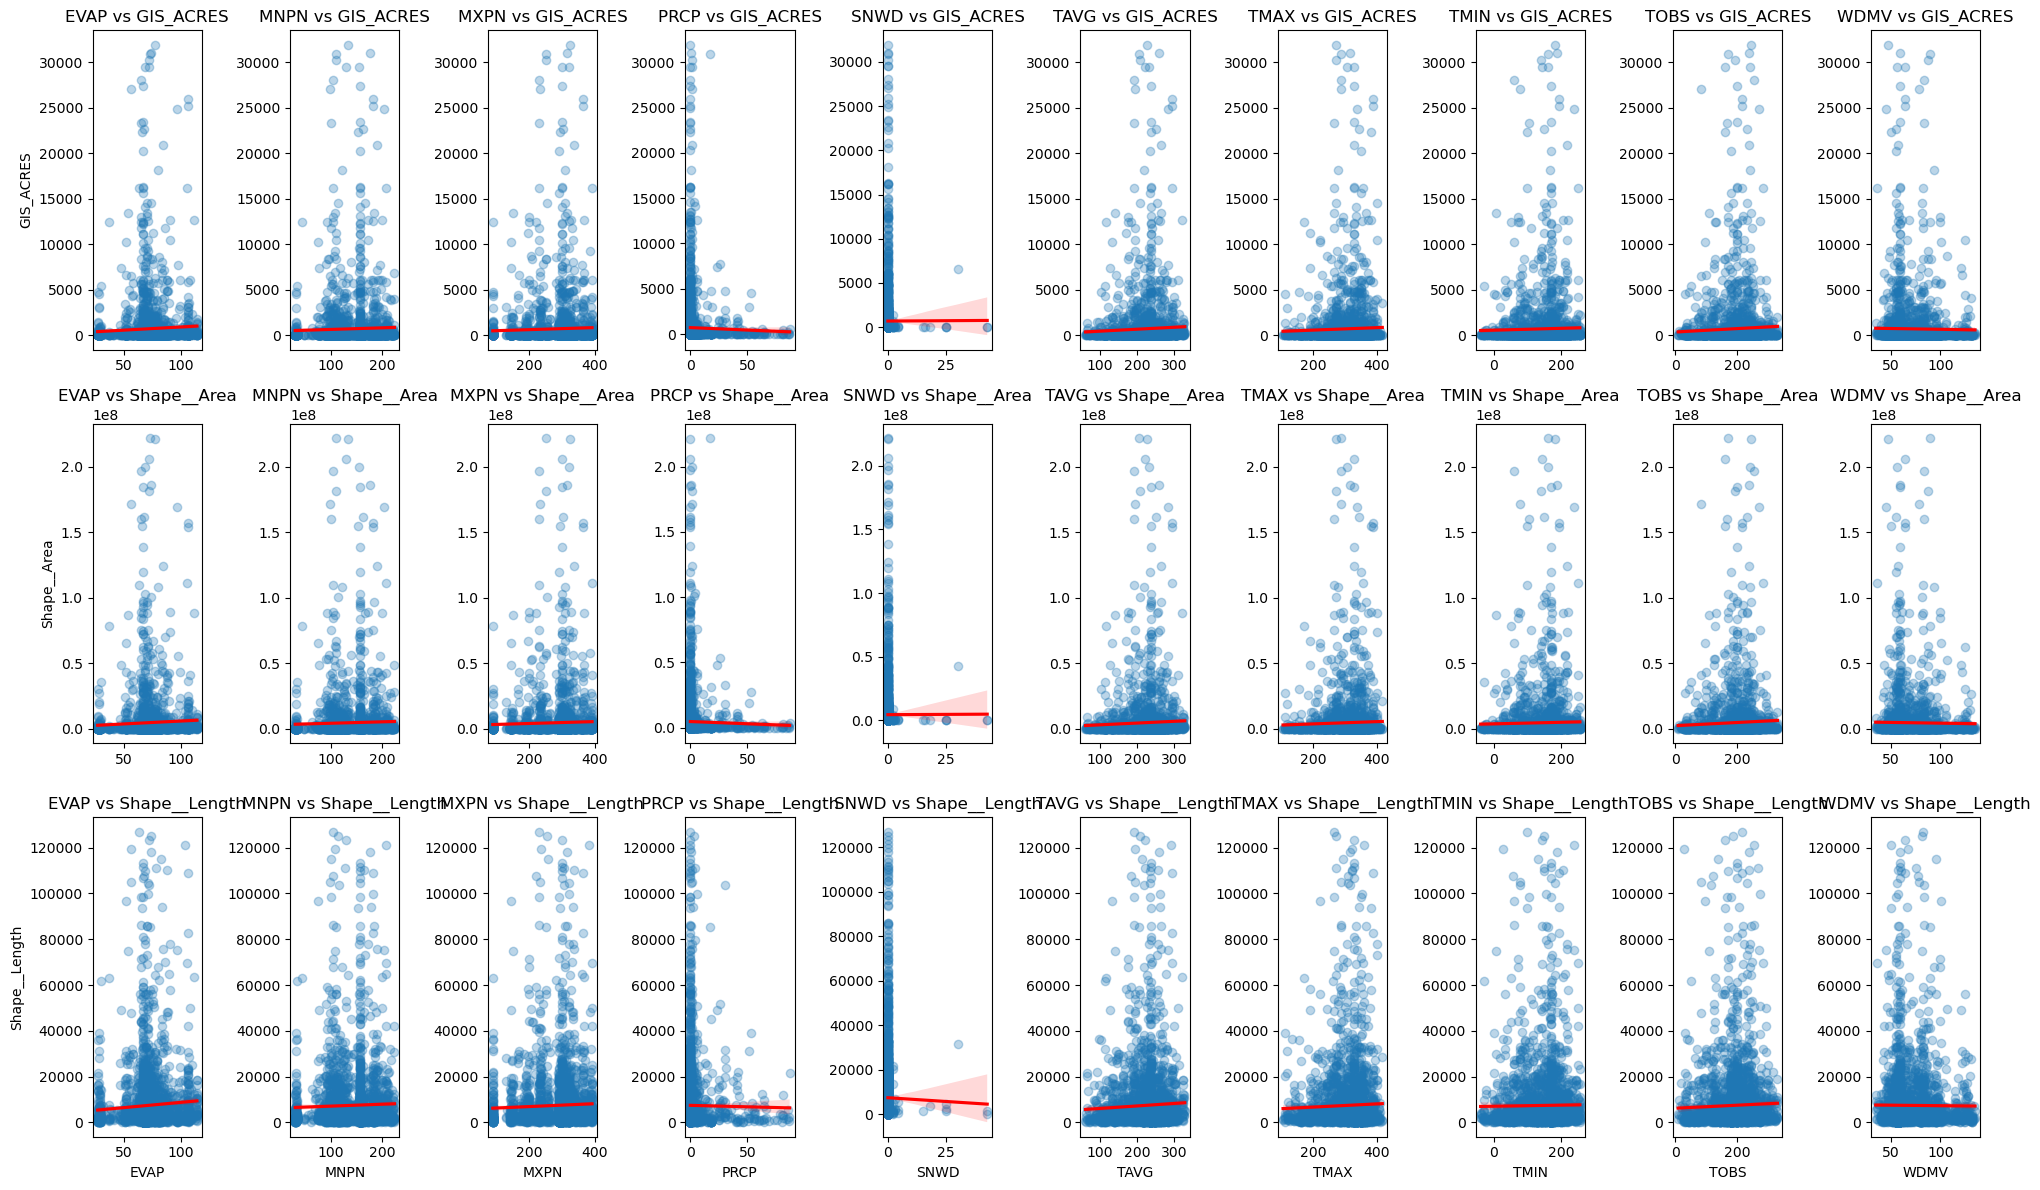

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define features and targets
features = ['EVAP', 'MNPN', 'MXPN', 'PRCP', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'TOBS', 'WDMV']
targets = ['GIS_ACRES', 'Shape__Area', 'Shape__Length']

# Function to remove extreme outliers based on percentiles
def remove_outliers(df, feature, target, lower=1, upper=99):
    lower_bound_feature, upper_bound_feature = np.percentile(df[feature].dropna(), [lower, upper])
    lower_bound_target, upper_bound_target = np.percentile(df[target].dropna(), [lower, upper])
    
    return df[
        (df[feature] >= lower_bound_feature) & (df[feature] <= upper_bound_feature) & 
        (df[target] >= lower_bound_target) & (df[target] <= upper_bound_target)
    ]

# Create a figure with subplots
fig, axes = plt.subplots(len(targets), len(features), figsize=(20, 12))

# Loop through each target and feature to create scatter plots
for i, target in enumerate(targets):
    for j, feature in enumerate(features):
        # Remove extreme outliers for this feature-target pair
        filtered_data = remove_outliers(pivoted_weather_ready, feature, target)
        
        # Create a scatter plot in the respective subplot
        ax = axes[i, j]
        
        sns.regplot(x=filtered_data[feature], 
                    y=filtered_data[target], 
                    scatter_kws={'alpha': 0.3},  # Transparency for overlapping points
                    line_kws={'color': 'red'},   # Regression line in red
                    ax=ax)
        
        # Set titles and labels
        if i == len(targets) - 1:  # Only label x-axis in the last row
            ax.set_xlabel(feature)
        else:
            ax.set_xlabel('')
        
        if j == 0:  # Only label y-axis in the first column
            ax.set_ylabel(target)
        else:
            ax.set_ylabel('')
        
        ax.set_title(f"{feature} vs {target}")

# Adjust the layout for better spacing
plt.tight_layout()
plt.show()


### Distribution: fire area across years? (the variance is very high and if we are to use the time series regression model this is the first step)

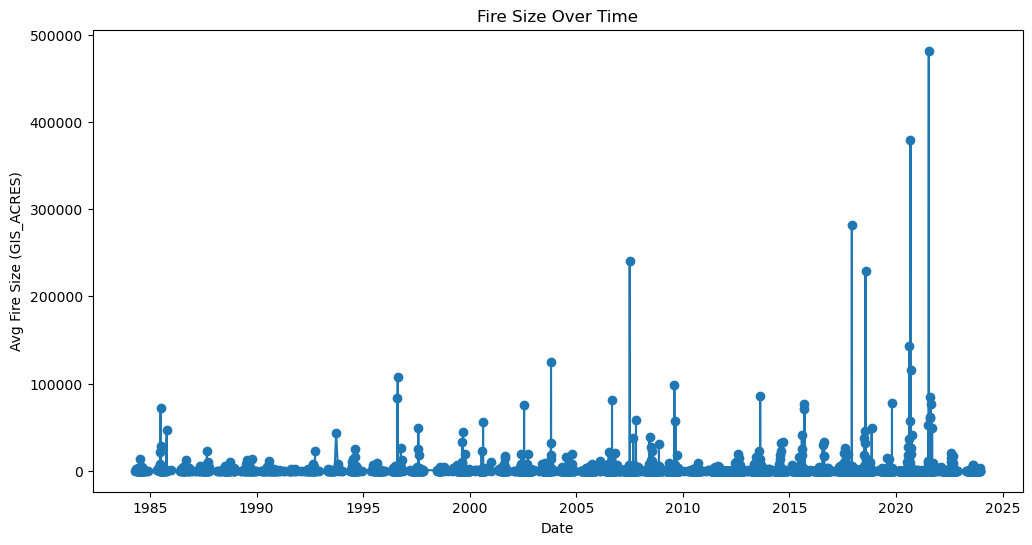

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
fire_data8423 = pd.read_csv(r'working data\fire_data8423.csv')
# Convert 'date' to datetime if not already
fire_data8423['ALARM_DATE'] = pd.to_datetime(fire_data8423['ALARM_DATE'])

# Plot fire size over time
plt.figure(figsize=(12, 6))
plt.plot(fire_data8423.groupby('ALARM_DATE')['GIS_ACRES'].mean(), marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Avg Fire Size (GIS_ACRES)')
plt.title('Fire Size Over Time')
plt.show()



### Try using only PRCP and SNDW, 4 years training, 2 years testing

In [ ]:
##to do the 4 years train data, 2 years test data

# Define train/test date ranges
train_start = '2017-01-01'
train_end = '2020-12-31'  # 4 years for training
test_start = '2021-01-01'
test_end = '2022-12-31' # 2 years for testing

# Train-test split using date ranges
train_data = pivoted_weather_ready[
    (pivoted_weather_ready['ALARM_DATE'] >= train_start) & 
    (pivoted_weather_ready['ALARM_DATE'] <= train_end)
]

test_data = pivoted_weather_ready[
    (pivoted_weather_ready['ALARM_DATE'] >= test_start) & 
    (pivoted_weather_ready['ALARM_DATE'] <= test_end)
]

X_train42 = train_data.loc[:,['PRCP']]
Y_train42 = train_data[['GIS_ACRES', 'Shape__Area', 'Shape__Length']]

X_test42 = test_data.loc[:, ['PRCP']]
Y_test42 = test_data[['GIS_ACRES', 'Shape__Area', 'Shape__Length']]

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train Model
model42 = RandomForestRegressor(n_estimators=10, random_state=42)
model42.fit(X_train42, Y_train42)

# Predict
Y_pred_test42 = model42.predict(X_test42)
Y_pred_train42 = model42.predict(X_train42)

# Evaluate Performance
mse_test = mean_squared_error(Y_test42, Y_pred_test42)
r2_test = r2_score(Y_test42, Y_pred_test42)

# Evaluate Performance
mse_train = mean_squared_error(Y_train42, Y_pred_train42)
r2_train = r2_score(Y_train42, Y_pred_train42)


print(f'Mean Squared Error test: {mse_test:.4f}')
print(f'R² Score test: {r2_test:.4f}')

print(f'Mean Squared Error train: {mse_train:.4f}')
print(f'R² Score train: {r2_train:.4f}')


Mean Squared Error test: 56622671892498376.0000
R² Score test: -0.0112
Mean Squared Error train: 11052149273003928.0000
R² Score train: 0.6257


Above cell: just using PRCP does not give a high R2 score for training set either:: there are other factors important here

### Trying time series regression


1.Test for stationarity (which our data is non-stationary since there is an increasing trend across the year-- not a recurring pattern)

KPSS (Kwiatkowski-Phillips-Schmidt-Shin) test checks for trend stationarity in a time series. It is the opposite of the ADF test in terms of hypothesis testing.
##if KPSS pvalue < 0.02 -- non stationary

In [ ]:
from statsmodels.tsa.stattools import kpss

kpss_result = kpss(fire_data8423['GIS_ACRES'], regression="c")  # Test for stationarity
print("KPSS p-value:", kpss_result[1])
##if KPSS pvalue < 0.02 -- non stationary


KPSS p-value: 0.02007175940751702



##### my decision here: lets try using Log transformation to see if the *very skewed* data fit better to the model 

Log transfomration

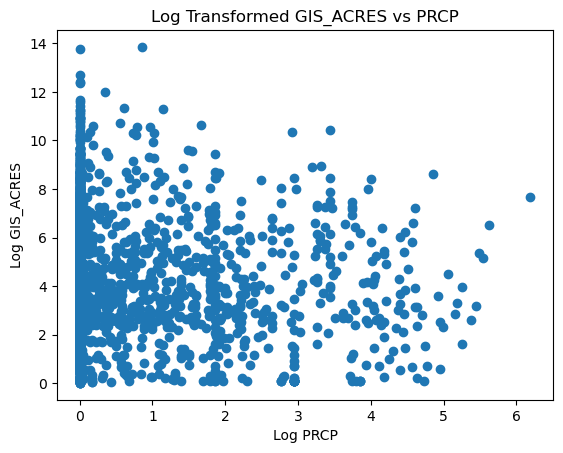

In [ ]:
import numpy as np

# Add a small constant to avoid log(0)
pivoted_weather_ready['log_GIS_ACRES'] = np.log1p(pivoted_weather_ready['GIS_ACRES'])
pivoted_weather_ready['log_PRCP'] = np.log1p(pivoted_weather_ready['PRCP'])

# Plot log-transformed data
plt.scatter(pivoted_weather_ready['log_PRCP'], pivoted_weather_ready['log_GIS_ACRES'])
plt.xlabel('Log PRCP')
plt.ylabel('Log GIS_ACRES')
plt.title('Log Transformed GIS_ACRES vs PRCP')
plt.show()

#### bad news: we have a lot of no rain (PRCP=0) situation
(look at the distribution)

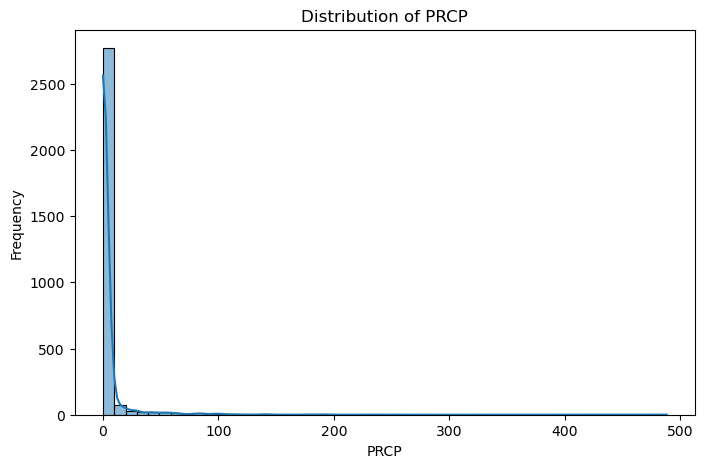

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(pivoted_weather_ready['PRCP'], bins=50, kde=True)
plt.xlabel("PRCP")
plt.ylabel("Frequency")
plt.title("Distribution of PRCP")
plt.show()


### stat to generally describe the relationship between PRCP and Fire area

In [ ]:
no_rain_stats = no_rain_data['GIS_ACRES'].describe()
rain_stats = rain_data['GIS_ACRES'].describe()

print("No Rain Stats:\n", no_rain_stats)
print("\nRain Stats:\n", rain_stats)

No Rain Stats:
 count    2.772000e+03
mean     2.258386e+03
std      2.904671e+04
min      1.678047e-02
25%      1.193522e+01
50%      3.842949e+01
75%      2.100935e+02
max      1.032700e+06
Name: GIS_ACRES, dtype: float64

Rain Stats:
 count      205.000000
mean       753.472842
std       3366.416002
min          0.079365
25%          5.748158
50%         26.976840
75%        299.751300
max      34236.260000
Name: GIS_ACRES, dtype: float64


check for seasonal pattern in fire data:

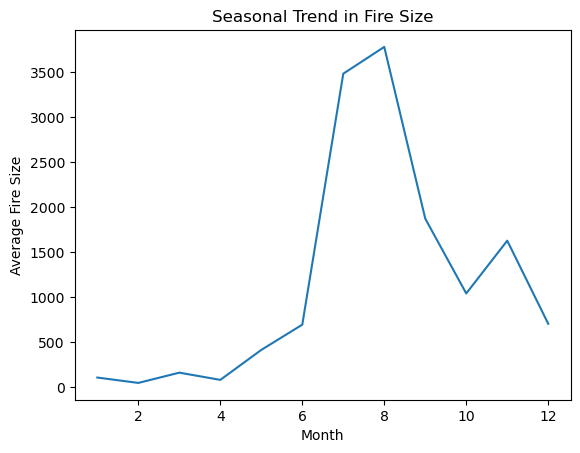

In [ ]:
pivoted_weather_ready['month'] = pivoted_weather_ready['ALARM_DATE'].dt.month
pivoted_weather_ready.groupby('month')['GIS_ACRES'].mean().plot(kind='line')
plt.xlabel("Month")
plt.ylabel("Average Fire Size")
plt.title("Seasonal Trend in Fire Size")
plt.show()


##### yep as expected: season matters
we can do seasonal time series model:
##### chatgpt said:XGBoost regression model could
✅ Train vs Train Predictions (R², MSE)
✅ Test vs Test Predictions (R², MSE)
✅ Time-based split (before/after split_year)
✅ Feature engineering (seasonality + lag features)

### XGBoost 
with train vs train pred, test vs test pred (to show the overfitting )
time base split (not use future year to predict backwards)
seasonality
##### crazy ovefit we are going back to RF

## HOW COULD I FORGET TO PUT MY LOCATION COLUMN IN ?????
okay ill repeat but this time with the locations 



### updated code chunk that includes the location-specific time-based splits, ensures no data leakage, and applies the random forest model on a per-location basis:

In [19]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder

# Ensure ALARM_DATE is in datetime format
pivoted_weather_ready['ALARM_DATE'] = pd.to_datetime(pivoted_weather_ready['ALARM_DATE'])

# Feature Engineering for Time Series Regression
pivoted_weather_ready['month'] = pivoted_weather_ready['ALARM_DATE'].dt.month  # Capture seasonality
pivoted_weather_ready['year'] = pivoted_weather_ready['ALARM_DATE'].dt.year    # Capture trend

# Check if data is monthly or daily
time_diff = pivoted_weather_ready['ALARM_DATE'].diff().median()  # Median time difference
is_monthly = time_diff > pd.Timedelta(days=25)

# Create lag feature based on data frequency
if is_monthly:
    pivoted_weather_ready['prev_fire_size'] = pivoted_weather_ready['GIS_ACRES'].shift(12)  # 1 year back (12 months)
else:
    pivoted_weather_ready['prev_fire_size'] = pivoted_weather_ready['GIS_ACRES'].shift(365)  # 1 year back (365 days)

# Drop NaNs (caused by shifting)
pivoted_weather_ready.dropna(inplace=True)

# Define Features and Target
weather_features = ['EVAP', 'TAVG', 'MNPN', 'MXPN','PRCP', 'WDMV']  # Add more key weather features as needed
features = ['month', 'prev_fire_size'] + weather_features  # Include more relevant features

# Store the 'weatherstn' column separately before one-hot encoding
weatherstn_column = pivoted_weather_ready['weatherstn']

# One-hot encode the 'weatherstn' feature (without dropping the first column)
pivoted_weather_ready = pd.get_dummies(pivoted_weather_ready, columns=['weatherstn'])  # No drop_first here

# Re-merge the original 'weatherstn' column back into the dataframe (for use in splitting)
pivoted_weather_ready['weatherstn'] = weatherstn_column

# Now include the encoded location features in your model input
X = pivoted_weather_ready[features + [col for col in pivoted_weather_ready.columns if col.startswith('weatherstn_')]]
y = pivoted_weather_ready['GIS_ACRES']

# Split the data by location to ensure trends are captured per location
locations = pivoted_weather_ready['weatherstn'].unique()

X_train_list = []
y_train_list = []
X_test_list = []
y_test_list = []

# Split data by location
for loc in locations:
    loc_data = pivoted_weather_ready[pivoted_weather_ready['weatherstn'] == loc]
    
    # Time-based split for this location
    train_loc = loc_data[loc_data['year'] < 2015]
    test_loc = loc_data[loc_data['year'] >= 2015]
    
    X_train_list.append(train_loc[features + [col for col in train_loc.columns if col.startswith('weatherstn_')]])
    y_train_list.append(train_loc['GIS_ACRES'])
    
    X_test_list.append(test_loc[features + [col for col in test_loc.columns if col.startswith('weatherstn_')]])
    y_test_list.append(test_loc['GIS_ACRES'])

# Concatenate data for training and testing (now location-specific)
X_train = pd.concat(X_train_list)
y_train = pd.concat(y_train_list)
X_test = pd.concat(X_test_list)
y_test = pd.concat(y_test_list)

# 1. Define the RandomForestRegressor model
model = RandomForestRegressor(random_state=42, n_estimators=10)



In [20]:
# 2. Train the model
model.fit(X_train, y_train)

# 3. Make Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 4. Evaluate Model Performance (MSE and R²)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# 5. Print Results
print(f"Train MSE: {mse_train:.4f}, Train R²: {r2_train:.4f}")
print(f"Test MSE: {mse_test:.4f}, Test R²: {r2_test:.4f}")

# Optional: Cross-validated MSE using Random Forest
cv_results = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')  # 5-fold CV
print(f"Cross-validated MSE: {-cv_results.mean():.4f}")



Train MSE: 20920485.0629, Train R²: 0.7481
Test MSE: 2098438361.7787, Test R²: -0.0106
Cross-validated MSE: 6466332918.7337


In [202]:
#rename the dataframe
pivoted_weather_ready = pd.read_csv(r'working data\pivotedweather_fire_imputated.csv')
# Drop column: 'SNOW'
#pivoted_weather_ready = pivoted_weather_ready.drop(columns=['SNOW'])
# Define Features (X) and Target (y)

X = pivoted_weather_ready.loc[:, 'EVAP':'WDMV']  # Select numerical features
Y = pivoted_weather_ready[['GIS_ACRES', 'Shape__Area', 'Shape__Length']]  # Target variables

In [203]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Ensure ALARM_DATE is in datetime format
pivoted_weather_ready['ALARM_DATE'] = pd.to_datetime(pivoted_weather_ready['ALARM_DATE'])

# Feature Engineering for Time Series Regression
pivoted_weather_ready['month'] = pivoted_weather_ready['ALARM_DATE'].dt.month  # Capture seasonality
pivoted_weather_ready['year'] = pivoted_weather_ready['ALARM_DATE'].dt.year    # Capture trend

# Check if data is monthly or daily
time_diff = pivoted_weather_ready['ALARM_DATE'].diff().median()  # Median time difference
is_monthly = time_diff > pd.Timedelta(days=25)

# Create lag feature based on data frequency
if is_monthly:
    pivoted_weather_ready['prev_fire_size'] = pivoted_weather_ready['GIS_ACRES'].shift(12)  # 1 year back (12 months)
else:
    pivoted_weather_ready['prev_fire_size'] = pivoted_weather_ready['GIS_ACRES'].shift(365)  # 1 year back (365 days)

# Drop NaNs (caused by shifting)
pivoted_weather_ready.dropna(inplace=True)

# Define Features and Target
weather_features = ['EVAP', 'TAVG', 'MNPN', 'MXPN', 'PRCP', 'WDMV']  # Add more key weather features as needed
features = ['month', 'prev_fire_size'] + weather_features  # Include more relevant features

# One-hot encode the 'weatherstn' feature (as location)
pivoted_weather_ready = pd.get_dummies(pivoted_weather_ready, columns=['weatherstn'], drop_first=True)

# Now include the encoded location features in your model input
X = pivoted_weather_ready[features + [col for col in pivoted_weather_ready.columns if col.startswith('weatherstn_')]]
y = pivoted_weather_ready['GIS_ACRES']

# Time-based split for training and testing (avoiding data leakage)
split_year = 2015
train = pivoted_weather_ready[pivoted_weather_ready['year'] < split_year]
test = pivoted_weather_ready[pivoted_weather_ready['year'] >= split_year]

X_train, y_train = train[features + [col for col in train.columns if col.startswith('weatherstn_')]], train['GIS_ACRES']
X_test, y_test = test[features + [col for col in test.columns if col.startswith('weatherstn_')]], test['GIS_ACRES']

# Scale the data using MinMaxScaler (to help with tree-based models)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Define the RandomForestRegressor model
model = RandomForestRegressor(random_state=42)

# 2. Hyperparameter Grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 80],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}


# 3. GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1, scoring='neg_mean_squared_error', verbose=2)

# 4. Fit GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# 5. Print best hyperparameters found by GridSearchCV
print(f"Best hyperparameters: {grid_search.best_params_}")

# 6. Get the best model
best_model = grid_search.best_estimator_

# 7. Make Predictions using the best model
y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)

# 8. Evaluate Model Performance
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# 9. Print Results
print(f"Train MSE: {mse_train:.4f}, Train R²: {r2_train:.4f}")
print(f"Test MSE: {mse_test:.4f}, Test R²: {r2_test:.4f}")

# Optional: Cross-validated MSE using the best model
cv_results = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')  # 5-fold CV
print(f"Cross-validated MSE: {-cv_results.mean():.4f}")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=80; total time=   0.5s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=80; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=80; total time=   0.4s
[CV] END bootstrap=

### Model test1 : try with RandomForestRegressor

In [49]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Assuming pivoted_weather_ready is your DataFrame

# Prepare the data
X = pivoted_weather_ready.loc[:, 'PRCP':'WDMV']  # Replace with actual feature columns
y = pivoted_weather_ready['GIS_ACRES']

# Apply log transformation to the target variable
y_log = np.log1p(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree Regressor with hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Cross-validation
scores = cross_val_score(best_model, X, y_log, cv=5, scoring='r2')
print(f"Cross-validated R^2 scores: {scores}")
print(f"Mean R^2 score: {scores.mean()}")

Best parameters: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
Mean Squared Error: 5.110152468980494
R^2 Score: 0.018176439758419205
Cross-validated R^2 scores: [-0.12648325  0.04893115 -0.06805504  0.02558457 -0.03653384]
Mean R^2 score: -0.031311283572224013


### Model test2: Repeat with RandomForestRegressor

In [61]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Assuming pivoted_weather_ready is your DataFrame

# Prepare the data
X = pivoted_weather_ready.loc[:,['TMAX','PRCP']]  # Replace with actual feature columns
y = pivoted_weather_ready['GIS_ACRES']



# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
'''
# Initialize and train the Random Forest Regressor with hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_
'''
# Initialize the Decision Tree Regressor
model = DecisionTreeRegressor(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
from sklearn.metrics import mean_squared_error, r2_score

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")



Mean Squared Error: 90104959.3394648
R^2 Score: -0.4939801863951929


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Assuming pivoted_weather_ready is your DataFrame

# Prepare the data
X = pivoted_weather_ready['PRCP']  # Replace with actual feature columns
y = pivoted_weather_ready['GIS_ACRES']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
'''
# Initialize and train the Decision Tree Regressor with hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_
'''
# Initialize the Decision Tree Regressor
model = DecisionTreeRegressor(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
from sklearn.metrics import mean_squared_error, r2_score

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")



Mean Squared Error: 128582109.01508293
R^2 Score: -1.1319483922046865


In [ ]:
##to do the 4 years train data, 2 years test data

# Define train/test date ranges
train_start = '2017-01-01'
train_end = '2020-12-31'  # 4 years for training
test_start = '2021-01-01'
test_end = '2022-12-31' # 2 years for testing

# Train-test split using date ranges
train_data = pivoted_weather_ready[
    (pivoted_weather_ready['ALARM_DATE'] >= train_start) & 
    (pivoted_weather_ready['ALARM_DATE'] <= train_end)
]

test_data = pivoted_weather_ready[
    (pivoted_weather_ready['ALARM_DATE'] >= test_start) & 
    (pivoted_weather_ready['ALARM_DATE'] <= test_end)
]

X_train42 = train_data.loc[:, 'EVAP':'WDMV']
Y_train42 = train_data[['GIS_ACRES', 'Shape__Area', 'Shape__Length']]

X_test42 = test_data.loc[:, 'EVAP':'WDMV']
Y_test42 = test_data[['GIS_ACRES', 'Shape__Area', 'Shape__Length']]

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train Model
model42 = RandomForestRegressor(n_estimators=5, random_state=42)
model42.fit(X_train42, Y_train42)

# Predict
Y_pred42 = model42.predict(X_test42)

# Evaluate Performance
mse = mean_squared_error(Y_test42, Y_test42)
r2 = r2_score(Y_test42, Y_pred42)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R² Score: {r2:.4f}')


Mean Squared Error: 0.0000
R² Score: -0.0490


## RANDOMFOREST might not be capturing high correlation variables (decision trees are less smooth)

try using GAM instead of RF (refer to notion logbook5 for the exact reason + comparison)

### GAM doesnt work: try xgboost
BUT xgboost doesnt take correlation into account so its as bad as rf here

In [18]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Prepare features and target
X = pivoted_weather_ready.loc[:, 'PRCP':'WDMV'].values  # Use all features in this range
y = pivoted_weather_ready['GIS_ACRES'].values  # Target variable

# Apply log transformation to the target
y_log = np.log1p(y)  # log(1 + y) to handle zeros

# Remove outliers using IQR filtering
Q1 = np.percentile(y_log, 25)
Q3 = np.percentile(y_log, 75)
IQR = Q3 - Q1
low_bound = Q1 - 1.5 * IQR
high_bound = Q3 + 1.5 * IQR
mask = (y_log >= low_bound) & (y_log <= high_bound)
X, y_log = X[mask], y_log[mask]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Train XGBoost model with optimized hyperparameters
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,  # Increase trees for better performance
    learning_rate=0.01,  # Lower learning rate for better stability
    max_depth=7,  # Slightly deeper trees
    subsample=0.9,  # Use 90% of data per tree
    colsample_bytree=0.9,  # Use 90% of features per tree
    gamma=0.2,  # Stronger regularization
    reg_alpha=0.5,  # Higher L1 regularization
    reg_lambda=1.5,  # Higher L2 regularization
    min_child_weight=5,  # Reduce overfitting by requiring minimum samples in leaf nodes
    random_state=42
)
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=True)  # Add early stopping

# Make predictions (convert back from log scale)
y_pred_log = xgb_model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # Reverse log transformation

# Evaluate performance
mse = mean_squared_error(np.expm1(y_test), y_pred)  # Convert y_test back for correct MSE
r2 = r2_score(np.expm1(y_test), y_pred)  # Correct R² calculation
print(f"XGBoost MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")


[0]	validation_0-rmse:2.10132
[1]	validation_0-rmse:2.09969
[2]	validation_0-rmse:2.09790
[3]	validation_0-rmse:2.09621
[4]	validation_0-rmse:2.09496
[5]	validation_0-rmse:2.09320
[6]	validation_0-rmse:2.09163
[7]	validation_0-rmse:2.08995
[8]	validation_0-rmse:2.08839
[9]	validation_0-rmse:2.08701
[10]	validation_0-rmse:2.08550
[11]	validation_0-rmse:2.08436
[12]	validation_0-rmse:2.08287
[13]	validation_0-rmse:2.08138
[14]	validation_0-rmse:2.08007
[15]	validation_0-rmse:2.07879
[16]	validation_0-rmse:2.07707
[17]	validation_0-rmse:2.07562
[18]	validation_0-rmse:2.07453
[19]	validation_0-rmse:2.07331
[20]	validation_0-rmse:2.07227
[21]	validation_0-rmse:2.07074
[22]	validation_0-rmse:2.06971
[23]	validation_0-rmse:2.06841
[24]	validation_0-rmse:2.06742
[25]	validation_0-rmse:2.06651
[26]	validation_0-rmse:2.06582
[27]	validation_0-rmse:2.06524
[28]	validation_0-rmse:2.06431
[29]	validation_0-rmse:2.06311
[30]	validation_0-rmse:2.06220


c:\Users\natal\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-rmse:2.06117
[32]	validation_0-rmse:2.06033
[33]	validation_0-rmse:2.05920
[34]	validation_0-rmse:2.05842
[35]	validation_0-rmse:2.05744
[36]	validation_0-rmse:2.05622
[37]	validation_0-rmse:2.05552
[38]	validation_0-rmse:2.05500
[39]	validation_0-rmse:2.05437
[40]	validation_0-rmse:2.05338
[41]	validation_0-rmse:2.05263
[42]	validation_0-rmse:2.05182
[43]	validation_0-rmse:2.05131
[44]	validation_0-rmse:2.05064
[45]	validation_0-rmse:2.05029
[46]	validation_0-rmse:2.04984
[47]	validation_0-rmse:2.04914
[48]	validation_0-rmse:2.04817
[49]	validation_0-rmse:2.04762
[50]	validation_0-rmse:2.04686
[51]	validation_0-rmse:2.04599
[52]	validation_0-rmse:2.04557
[53]	validation_0-rmse:2.04508
[54]	validation_0-rmse:2.04408
[55]	validation_0-rmse:2.04353
[56]	validation_0-rmse:2.04240
[57]	validation_0-rmse:2.04189
[58]	validation_0-rmse:2.04090
[59]	validation_0-rmse:2.04063
[60]	validation_0-rmse:2.03986
[61]	validation_0-rmse:2.03958
[62]	validation_0-rmse:2.03927
[63]	val

#### most data falls in 0

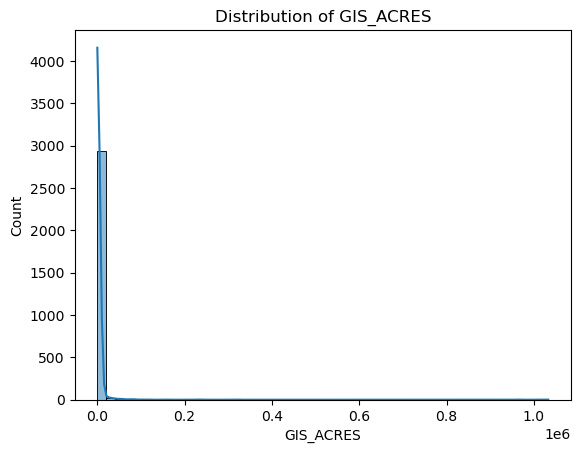

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(pivoted_weather_ready['GIS_ACRES'], bins=50, kde=True)
plt.title("Distribution of GIS_ACRES")
plt.show()


### Step 1: Apply Yeo-Johnson Power Transformation to features and target (both positive and zero/negative)

In [119]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Prepare features and target
X = pivoted_weather_ready.loc[:,'EVAP':'WDMV'].values  # Feature matrix
y = pivoted_weather_ready['GIS_ACRES'].values  # Target variable

# Step 1: Apply Yeo-Johnson Power Transformation to features and target (both positive and zero/negative)
pt = PowerTransformer(method='yeo-johnson')

# Transform the feature matrix
X_transformed = pt.fit_transform(X)

# Transform the target variable
y_transformed = pt.fit_transform(y.reshape(-1, 1)).flatten()


### Conclusion from the above code cell:
1. powertransformer with yeo-johnson works to transform before RF

#### The below cell is loading data and put everything in (without any machine model)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Convert 'ALARM_DATE' to datetime format (if not already)
pivoted_weather_ready['ALARM_DATE'] = pd.to_datetime(pivoted_weather_ready['ALARM_DATE'])

# Define the split year (80% train, 20% test)
split_year = 2015  

# Train set: data before split_year
train_data = pivoted_weather_ready[pivoted_weather_ready['ALARM_DATE'].dt.year < split_year]
# Test set: data from split_year onwards
test_data = pivoted_weather_ready[pivoted_weather_ready['ALARM_DATE'].dt.year >= split_year]

# Extract features and target
X_train, y_train = train_data.loc[:, 'EVAP':'WDMV'], train_data['GIS_ACRES']
X_test, y_test = test_data.loc[:, 'EVAP':'WDMV'], test_data['GIS_ACRES']


Random Forest Train Set MSE: 0.4144
Random Forest Train Set R² Score: 0.5856
Random Forest Test Set MSE: 1.2857
Random Forest Test Set R² Score: -0.2414


In [ ]:

# Convert target to NumPy arrays (fixing the reshape error)
#reshape y_train and y_test because PowerTransformer.fit_transform() expects a 2D array, but y_train and y_test are pandas Series (which are 1D by default).
y_train = y_train.to_numpy().reshape(-1, 1)
y_test = y_test.to_numpy().reshape(-1, 1)

# Apply Yeo-Johnson Power Transformation
pt_X = PowerTransformer(method='yeo-johnson')
pt_y = PowerTransformer(method='yeo-johnson')

# Transform features
X_train_transformed = pt_X.fit_transform(X_train)  # Fit and transform on training set
X_test_transformed = pt_X.transform(X_test)  # Transform test set

# Transform the target variable (only fit on training set!)
y_train_transformed = pt_y.fit_transform(y_train).flatten()
y_test_transformed = pt_y.transform(y_test).flatten()

# Train Random Forest
rf = RandomForestRegressor(n_estimators=10, random_state=42)
rf.fit(X_train_transformed, y_train_transformed)

# Make predictions
y_train_pred_rf = rf.predict(X_train_transformed)  # Predict on training set
y_test_pred_rf = rf.predict(X_test_transformed)  # Predict on test set

# Evaluate the model
mse_rf_train = mean_squared_error(y_train_transformed, y_train_pred_rf)
r2_rf_train = r2_score(y_train_transformed, y_train_pred_rf)

mse_rf_test = mean_squared_error(y_test_transformed, y_test_pred_rf)
r2_rf_test = r2_score(y_test_transformed, y_test_pred_rf)

# Print results
print(f"Random Forest Train Set MSE: {mse_rf_train:.4f}")
print(f"Random Forest Train Set R² Score: {r2_rf_train:.4f}")

print(f"Random Forest Test Set MSE: {mse_rf_test:.4f}")
print(f"Random Forest Test Set R² Score: {r2_rf_test:.4f}")


#### so from above: the R2 score for train vs prediction from train is alright (0.6...)
but the test vs prediction from test set has really low R2:

##### question tho: what if we cant just do random years in train test split: we have to split it into 0.8 0.2 as in consecutive years?

### Step 2: Try PCR (Principal Component Regression)

In [120]:
# Step 2: Try PCR (Principal Component Regression)
pcr = Pipeline([
    ('pca', PCA(n_components=5)),  # Reduce to top 5 principal components
    ('regressor', LinearRegression())
])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_transformed, test_size=0.2, random_state=42)

# Train PCR model
pcr.fit(X_train, y_train)

# Make predictions
y_pred_pcr = pcr.predict(X_test)

# Evaluate PCR
mse_pcr = mean_squared_error(y_test, y_pred_pcr)
r2_pcr = r2_score(y_test, y_pred_pcr)

print(f"PCR MSE: {mse_pcr:.4f}")
print(f"PCR R² Score: {r2_pcr:.4f}")



PCR MSE: 0.9490
PCR R² Score: 0.0184


### Step 3: Try Random Forest if PCR doesn't improve

In [121]:

# Step 3: Try Random Forest if PCR doesn't improve
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

# Evaluate Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MSE: {mse_rf:.4f}")
print(f"Random Forest R² Score: {r2_rf:.4f}")


Random Forest MSE: 0.9454
Random Forest R² Score: 0.0221



### Step 4: Try XGBoost

In [122]:

# Step 4: Try XGBoost
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

# Evaluate XGBoost
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MSE: {mse_xgb:.4f}")
print(f"XGBoost R² Score: {r2_xgb:.4f}")


XGBoost MSE: 1.0254
XGBoost R² Score: -0.0607


### PCA to address multicolinearity before randomforest

In [118]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Create polynomial features (e.g., quadratic, interaction terms)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_poly, y_log, test_size=0.2, random_state=42)

# Train a linear regression model with polynomial features
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred_log = model.predict(X_test)

# Reverse the log transformation
y_pred = np.expm1(y_pred_log)

# Evaluate the model
mse = mean_squared_error(np.expm1(y_test), y_pred)
r2 = r2_score(np.expm1(y_test), y_pred)

print(f"Polynomial Regression MSE: {mse:.4f}")
print(f"Polynomial Regression R² Score: {r2:.4f}")


Polynomial Regression MSE: 61996757.8293
Polynomial Regression R² Score: -0.0279


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_log, test_size=0.2, random_state=42)

# Build the Neural Network model
model = Sequential()

# Input layer (X_scaled has 5 features)
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))

# Hidden layers
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))

# Output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=2)

# Make predictions
y_pred_log = model.predict(X_test)

# Reverse log transformation
y_pred = np.expm1(y_pred_log)

# Evaluate the model
mse = mean_squared_error(np.expm1(y_test), y_pred)
r2 = r2_score(np.expm1(y_test), y_pred)

print(f"Neural Network MSE: {mse:.4f}")
print(f"Neural Network R² Score: {r2:.4f}")
